In [16]:
from lstm_model import build_open_loop_lstm, load_open_loop_lstm
from data_processing import create_training_split, df_training_split, create_df_3d, create_window_closed_loop, add_new_pred, compute_lyapunov_time_arr, train_valid_test_split
import tensorflow_datasets as tfds
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

In [17]:
def df_train_valid_test_split(df, train_ratio=0.6, valid_ratio=0.2):
    len_df_col = len(df)
    train = np.array(df[:, 0:int(len_df_col*train_ratio)])
    valid = np.array(df[:, int(len_df_col*train_ratio): int(len_df_col*(train_ratio + valid_ratio))])
    test = np.array(df[:, int(len_df_col*(train_ratio+valid_ratio)):])
    return train, valid, test

In [19]:
mydf = np.genfromtxt('Lorenz_Data/CSV/Lorenz_trans_001.csv', delimiter=',')
time = mydf[0, :]
mydf = mydf[1:, :]
df_train, df_test = df_training_split(mydf)
time_train, time_valid, time_test = train_valid_test_split(time)
x_train, x_valid, x_test = train_valid_test_split(mydf[0, :])
y_train, y_valid, y_test = train_valid_test_split(mydf[1, :])
z_train, z_valid, z_test = train_valid_test_split(mydf[2, :])
window_size = 50
batch_size = 32
shuffle_buffer_size = df_train.shape[0]
train_dataset = create_df_3d(df_train.transpose(
), window_size, batch_size, shuffle_buffer_size)
test_dataset = create_df_3d(df_test.transpose(), window_size, batch_size, 1)

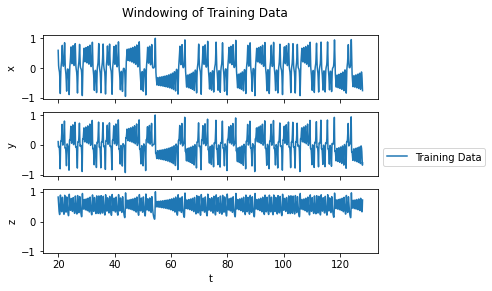

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(
    3, sharex=True, sharey=True)  # , figsize=(15, 15))
fig.suptitle('Windowing of Training Data')
ax1.plot(time_train, x_train)
ax1.set_ylabel('x')
ax2.plot(time_train, y_train)
ax2.set_ylabel('y')
ax3.plot(time_train, z_train, label='Training Data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.legend(loc='center left', bbox_to_anchor=(1, 1.5))
#fig.savefig('Images/train.png', dpi=200, facecolor="w", bbox_inches='tight')

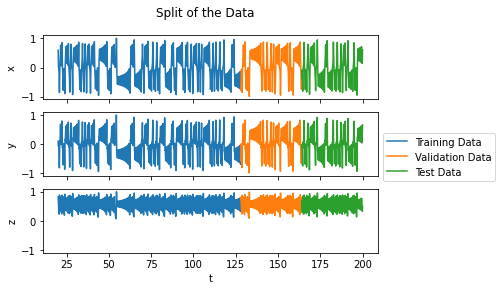

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(
    3, sharex=True, sharey=True)  # , figsize=(15, 15))
fig.suptitle('Split of the Data')
ax1.plot(time_train, x_train, time_valid, x_valid, time_test, x_test)
ax1.set_ylabel('x')
ax2.plot(time_train, y_train, time_valid, y_valid, time_test, y_test)
ax2.set_ylabel('y')
ax3.plot(time_train, z_train, label='Training Data')
ax3.plot(time_valid, z_valid, label='Validation Data')
ax3.plot(time_test, z_test, label='Test Data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
# ax3.set_xlim(0,1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 1.5))
#fig.savefig('Images/train_valid_test_split.png', dpi=200, facecolor="w", bbox_inches='tight')

In [22]:
model_checkpoint = 'models/oloop_lstm/200_epoch_cp'
model = build_open_loop_lstm()
# Restore the weights
model.load_weights(model_checkpoint)

In [23]:
test_window = create_window_closed_loop(df_test.transpose(), 0)
predictions = model.predict(test_window)
for iteration in range(1, 1950):
    test_window = create_window_closed_loop(
        df_test.transpose(), iteration, predictions)
    new_pred = model.predict(test_window)
    predictions = add_new_pred(predictions, new_pred)
predictions.shape

InvalidArgumentError:  Matrix size-incompatible: In[0]: [1,100], In[1]: [50,200]
	 [[node sequential_1/LSTM_1/while/lstm_cell_1/MatMul_1
 (defined at /Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/backend.py:2134)
]] [Op:__inference_predict_function_1297]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_1/LSTM_1/while/lstm_cell_1/MatMul_1:
In[0] sequential_1/LSTM_1/while/Placeholder_2 (defined at /Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/backend.py:4654)	
In[1] sequential_1/LSTM_1/while/lstm_cell_1/MatMul_1/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/Users/eo821/.pyenv/versions/3.8.10/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/Users/eo821/.pyenv/versions/3.8.10/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/eo821/.pyenv/versions/3.8.10/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/eo821/.pyenv/versions/3.8.10/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/eo821/.pyenv/versions/3.8.10/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/9k/f9m5_ygx7yj100hlsz7zc0bc0000gp/T/ipykernel_71878/2163513676.py", line 2, in <module>
>>>     predictions = model.predict(test_window)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/layers/recurrent.py", line 679, in __call__
>>>     return super(RNN, self).__call__(inputs, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/layers/recurrent_v2.py", line 1158, in call
>>>     last_output, outputs, states = backend.rnn(
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/backend.py", line 4654, in rnn
>>>     final_outputs = tf.compat.v1.while_loop(
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/backend.py", line 4640, in _step
>>>     output, new_states = step_function(current_input,
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/layers/recurrent_v2.py", line 1156, in step
>>>     return self.cell(inputs, states, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/layers/recurrent.py", line 2495, in call
>>>     z += backend.dot(h_tm1, self.recurrent_kernel)
>>> 
>>>   File "/Users/eo821/Documents/PhD_research/Lorenz_LSTM/venv/lib/python3.8/site-packages/keras/backend.py", line 2134, in dot
>>>     out = tf.matmul(x, y)
>>> 

Function call stack:
predict_function -> sequential_1_LSTM_1_while_body_1205


In [24]:
lyapunov_time = compute_lyapunov_time_arr(time_test)
lyapunov_path = 'Images/Lyapunov_wide_valid.png'

In [25]:
pred_closed_loop = predictions
test_time_end = 50+len(predictions)
fig, axs = plt.subplots(3, 2, sharey=True, facecolor="white", figsize=(15, 15))
fig.suptitle('Closed Loop LSTM Prediction')
axs[0, 0].plot(lyapunov_time[:test_time_end],
               x_test[50:test_time_end], label='True Data')
axs[0, 0].plot(lyapunov_time[:test_time_end],
               pred_closed_loop[:, 0], '--', label='RNN Prediction')
axs[0, 0].set_ylabel('x')
sns.kdeplot(x_test[50:test_time_end], vertical=True,
            color='tab:blue', ax=axs[0, 1])
sns.kdeplot(pred_closed_loop[:, 0], vertical=True,
            color='tab:orange', ax=axs[0, 1])
axs[1, 0].plot(lyapunov_time[:test_time_end],
               y_test[50:test_time_end], label='data')
axs[1, 0].plot(lyapunov_time[:test_time_end], pred_closed_loop[:,
               1], '--', label='RNN prediction on test data')
axs[1, 0].set_ylabel('y')
sns.kdeplot(y_test[50:test_time_end], vertical=True,
            color='tab:blue', ax=axs[1, 1])
sns.kdeplot(pred_closed_loop[:, 1], vertical=True,
            color='tab:orange', ax=axs[1, 1])
axs[2, 0].plot(lyapunov_time[:test_time_end],
               z_test[50:test_time_end], label='Numerical Solution')
axs[2, 0].plot(lyapunov_time[:test_time_end],
               pred_closed_loop[:, 2], '--', label='LSTM prediction')
axs[2, 0].set_ylabel('z')
axs[2, 0].set_xlabel('Lyapunov time')
axs[2, 0].set_ylim(-1, 1)
sns.kdeplot(z_test[50:test_time_end], vertical=True,
            color='tab:blue', ax=axs[2, 1])
sns.kdeplot(pred_closed_loop[:, 2], vertical=True,
            color='tab:orange', ax=axs[2, 1])
# ax3.set_xlim(5,10)
axs[2, 0].legend(loc='center left', bbox_to_anchor=(2.3, 2.0))
plt.show()
#fig.savefig(lyapunov_path, dpi=1000, facecolor="w", bbox_inches='tight')

NameError: name 'predictions' is not defined

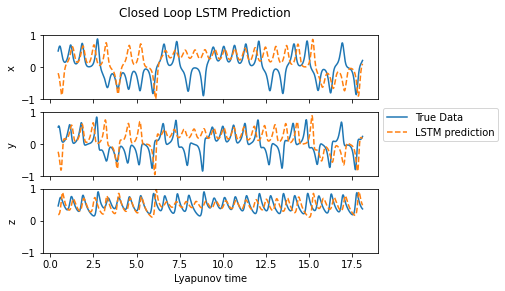

In [14]:
pred_closed_loop = predictions
test_time_end = 50+len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor="white")  # , figsize=(15, 15))
fig.suptitle('Closed Loop LSTM Prediction')
ax1.plot(lyapunov_time[:test_time_end],
         x_test[50:test_time_end], label='True Data')
ax1.plot(lyapunov_time[:test_time_end],
         pred_closed_loop[:, 0], '--', label='RNN Prediction')
ax1.set_ylabel('x')

ax2.plot(lyapunov_time[:test_time_end], y_test[50:test_time_end], label='data')
ax2.plot(lyapunov_time[:test_time_end], pred_closed_loop[:,
         1], '--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end],
         z_test[50:test_time_end], label='True Data')
ax3.plot(lyapunov_time[:test_time_end],
         pred_closed_loop[:, 2], '--', label='LSTM prediction')
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_ylim(-1, 1)
# ax3.set_xlim(5,10)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()
#fig.savefig(lyapunov_path, dpi=1000, facecolor="w", bbox_inches='tight')

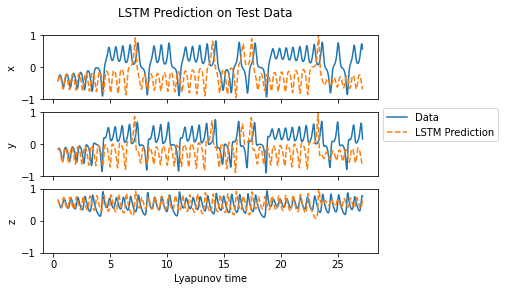

In [13]:
lyapunov_path = 'Images/Lyapunov_wide_valid.png'
pred_closed_loop = predictions
test_time_end = 50 + len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor="white")  # , figsize=(15, 15))
fig.suptitle('LSTM Prediction on Test Data')
ax1.plot(lyapunov_time[:test_time_end], x_test[50:test_time_end], label='data')
ax1.plot(lyapunov_time[:test_time_end], pred_closed_loop[:,
         0], '--', label='RNN prediction on test data')
ax1.set_ylabel('x')

ax2.plot(lyapunov_time[:test_time_end], y_test[50:test_time_end], label='data')
ax2.plot(lyapunov_time[:test_time_end], pred_closed_loop[:,
         1], '--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end], z_test[50:test_time_end], label='Data')
ax3.plot(lyapunov_time[:test_time_end],
         pred_closed_loop[:, 2], '--', label='LSTM Prediction')
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_ylim(-1, 1)
# ax3.set_xlim(0,5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()

#fig.savefig(lyapunov_path, dpi=1000, facecolor="w", bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


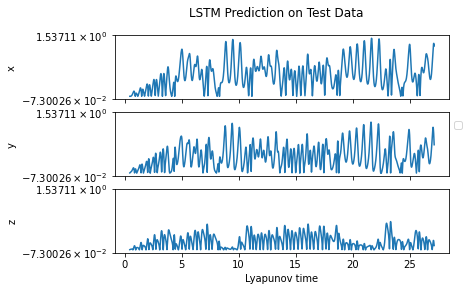

In [18]:
error_lyapunov_time = np.abs(df_test.transpose()[50:, :] - predictions)
test_time_end = 50 + len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor="white")  # , figsize=(15, 15))
fig.suptitle('LSTM Prediction on Test Data')
ax1.plot(lyapunov_time[:test_time_end], error_lyapunov_time[:, 0])
ax1.set_ylabel('x')
ax2.plot(lyapunov_time[:test_time_end], error_lyapunov_time[:, 1])
ax2.set_ylabel('y')
ax3.plot(lyapunov_time[:test_time_end], error_lyapunov_time[:, 2])
ax3.set_ylabel('z')
ax3.set_xlabel('Lyapunov time')
ax3.set_yscale('symlog')
# ax3.set_ylim(-0.1,10)
# ax3.set_xlim(0,5)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
plt.show()

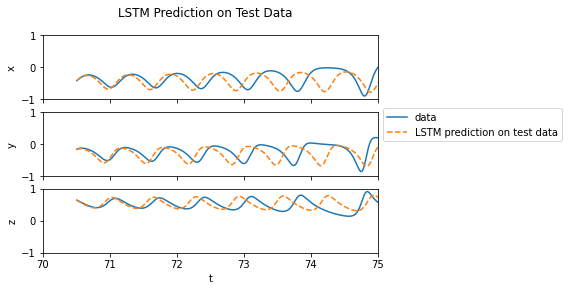

In [19]:
pred_closed_loop = predictions
test_time_end = 50 + len(predictions)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,
                                    sharey=True, facecolor="white")  # , figsize=(15, 15))
fig.suptitle('LSTM Prediction on Test Data')
ax1.plot(time_test[50:test_time_end], x_test[50:test_time_end], label='data')
ax1.plot(time_test[50:test_time_end], pred_closed_loop[:, 0],
         '--', label='RNN prediction on test data')
ax1.set_ylabel('x')

ax2.plot(time_test[50:test_time_end], y_test[50:test_time_end], label='data')
ax2.plot(time_test[50:test_time_end], pred_closed_loop[:, 1],
         '--', label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(time_test[50:test_time_end], z_test[50:test_time_end], label='data')
ax3.plot(time_test[50:test_time_end], pred_closed_loop[:, 2],
         '--', label='LSTM prediction on test data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.set_ylim(-1, 1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
ax3.set_xlim(70, 75)
plt.show()

In [22]:
forecast = model.predict(test_dataset)
testation_filepath = 'Results/prediction_testation'

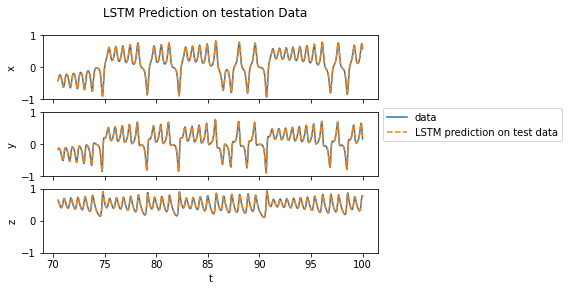

In [29]:
forecast = model.predict(test_dataset)
fig, (ax1, ax2, ax3) = plt.subplots(
    3, sharex=True, sharey=True)  # , figsize=(15, 15))
fig.suptitle('LSTM Prediction on testation Data')
ax1.plot(time_test[50:], x_test[50:], label='data')
ax1.plot(time_test[50:], forecast[:, 0], '--',
         label='RNN prediction on test data')
ax1.set_ylabel('x')
ax2.plot(time_test[50:], y_test[50:], label='data')
ax2.plot(time_test[50:], forecast[:, 1], '--',
         label='RNN prediction on test data')
ax2.set_ylabel('y')
ax3.plot(time_test[50:], z_test[50:], label='data')
ax3.plot(time_test[50:], forecast[:, 2], '--',
         label='LSTM prediction on test data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.set_ylim(-1, 1)
ax3.legend(loc='center left', bbox_to_anchor=(1, 2.0))
#fig.savefig(testation_filepath, dpi=1000, facecolor="w", bbox_inches='tight')

In [ ]:
err = df_test.transpose()[50:, :] - forecast
error_filepath = 'Results/absolute_error'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


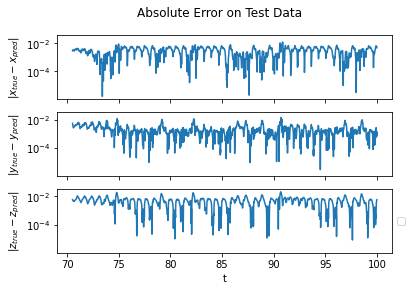

In [28]:
err = df_test.transpose()[50:, :] - forecast
abs_error = np.abs(df_test.transpose()[50:, :] - forecast)

fig, (ax1, ax2, ax3) = plt.subplots(
    3, sharex=True, sharey=True)  # , figsize=(15, 15))
fig.suptitle('Absolute Error on Test Data')
ax1.plot(time_test[50:], abs_error[:, 0])
ax1.set_ylabel(r'$|x_{true}-x_{pred}|$')
ax1.set_yscale('log')
ax2.plot(time_test[50:], abs_error[:, 1])
ax2.set_ylabel(r'$|y_{true}-y_{pred}|$')
ax2.set_yscale('log')
ax3.plot(time_test[50:], abs_error[:, 2])
ax3.set_ylabel(r'$|z_{true}-z_{pred}|$')
ax3.set_xlabel('t')
ax3.set_yscale('log')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig(error_filepath, dpi=1000, facecolor="w")